content\dsmall.jpg
K-medoids converged at 5 iterations.
K-means converged at 78 iterations.


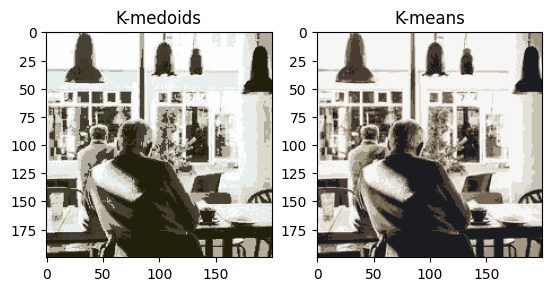

content\fsmall.jpg
K-medoids converged at 12 iterations.
K-means converged at 32 iterations.


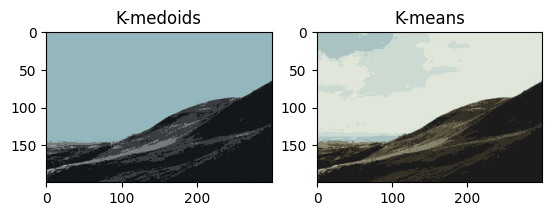

content\gsmall.jpg
K-medoids converged at 12 iterations.
K-means converged at 100 iterations.


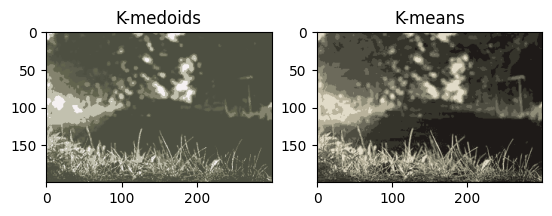

In [264]:
import numpy as np
import imageio.v2 as imageio
from matplotlib import pyplot as plt
import sys
import os
import scipy.io as sio
import io
from scipy.sparse import csc_matrix, find
import zipfile
from scipy.spatial.distance import cdist

        
def mykmeans(pixels, K):

    if pixels.max() > 1:
        pixels = pixels/255.0 

    if pixels.ndim ==3: 
        N = pixels.shape[0] * pixels.shape[1] 
        pixels = pixels.reshape(N,pixels.shape[2]) 
    else: 
        N = pixels.shape[0] 
            
    centroids = pixels[np.random.choice(N,K,replace=False)]     

    converged = 1e-5 
    current_iter = 0 
    max_iterations = 500 

    while current_iter < max_iterations:
        current_iter +=1 
        distances = np.sqrt(((pixels[:,np.newaxis]-centroids)**2).sum(axis=2))      
        clusters = np.argmin(distances, axis = 1) 
        count = np.bincount(clusters,minlength=K)
        new_centroids = np.zeros_like(centroids)
        
        for k in range(K):
            cluster_pts = pixels[clusters==k] 
            if len(cluster_pts)> 0: 
                new_centroids[k]=np.mean(cluster_pts,axis=0) 
            else: 
                new_centroids[k]=pixels[np.random.choice(N)]
                
        diff = np.linalg.norm(centroids-new_centroids, axis=1)
       
        if np.mean(diff)<converged:
            print(f"K-means converged at {current_iter} iterations.")
            break
            
        centroids=np.copy(new_centroids)
    
    centroids = centroids*255
    centroids= centroids.astype(np.uint8)
    return clusters, centroids
    
    

def mykmedoids(pixels, K):
    if pixels.max() > 1: 
        pixels = pixels/255.0 
        
    if pixels.ndim ==3: 
        N = pixels.shape[0] * pixels.shape[1] 
        pixels = pixels.reshape(N,pixels.shape[2]) 
    else: 
        N = pixels.shape[0] 
        
    medoids = pixels[np.random.choice(N, K, replace = False)]
    current_iter = 0 
    max_iterations = 300 
    converged = 1e-5 
 
    while current_iter < max_iterations:
        current_iter += 1 
        dist_to_medoids = compute_dist(pixels,medoids)
        clusters = np.argmin(dist_to_medoids,axis=1)
        new_medoids = np.zeros_like(medoids)
        
        for k in range(K): 
            cluster_pts = np.where(clusters == k)[0]

            if len(cluster_pts)>0: 
                distances = np.sum(dist_to_medoids[cluster_pts][:,k],axis=0)
                best_medoid = np.argmin(distances)
                new_medoids[k]=pixels[cluster_pts[best_medoid]]
            else: 
                new_medoids[k]=pixels[np.random.choice(N)]
        diff = np.linalg.norm(medoids-new_medoids,axis=1)
            
        if np.mean(diff)<converged:
            print(f"K-medoids converged at {current_iter} iterations.")
            break 
    
        medoids = np.copy(new_medoids)

    medoids = medoids*255
    medoids= medoids.astype(np.uint8)
    return clusters, medoids

def compute_dist(X,medoids):
    N,D = X.shape
    K = medoids.shape[0]
    return np.sqrt(np.sum((np.reshape(X,[N,1,D])-np.reshape(medoids,[1,K,D]))**2,axis=2))

def main():
    directory = "/content"  
    K = 5  
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            image_file_name = os.path.join(directory, filename)
            print(image_file_name)
            K = 5  

            im = np.asarray(imageio.imread(image_file_name))

            fig, axs = plt.subplots(1, 2)

           
            classes, centers = mykmedoids(im, K)
            new_im = np.asarray(centers[classes].reshape(im.shape), im.dtype)
            imageio.imwrite(os.path.basename(os.path.splitext(image_file_name)[0]) + '_converted_mykmedoids_' + str(K) + os.path.splitext(image_file_name)[1], new_im)
            axs[0].imshow(new_im)
            axs[0].set_title('K-medoids')

          
            classes, centers = mykmeans(im, K)
            new_im = np.asarray(centers[classes].reshape(im.shape), im.dtype)
            imageio.imwrite(os.path.basename(os.path.splitext(image_file_name)[0]) + '_converted_mykmeans_' + str(K) + os.path.splitext(image_file_name)[1], new_im)
            axs[1].imshow(new_im)
            axs[1].set_title('K-means')

            plt.show()

if __name__ == '__main__':
    main()

### 